In [1]:
import os
import tensorflow as tf
import pickle
import numpy as np
# import math as math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

C:\tools\Anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
def vgg16_model(image_shape=(32, 32, 3)):

    # model = tf.keras.Sequential()

    # # Remove the prediction layer and add to new model
    # for layer in vgg16_model.layers[:-1]: 
    #     model.add(layer)    

    # # Freeze the layers 
    # for layer in model.layers:
    #     layer.trainable = False

    # # Add 'softmax' instead of earlier 'prediction' layer.
    # model.add(tf.keras.layers.Dense(5, activation='softmax'))


    # reset_keras()

    # initialize the VGG16 model from the keras library
    vgg16_model = tf.keras.applications.VGG16(include_top=False,
                                              weights='imagenet',
                                              input_tensor=None,
                                              input_shape=image_shape,
                                              pooling=None,
                                              classes=5)

    model = tf.keras.Sequential()

#     for layer in vgg16_model.layers[:-1]: 
#         model.add(layer)


    # Freeze the layers
    for layer in model.layers:
        layer.trainable = False
    
    model.add(vgg16_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))

    # Add 'softmax' instead of earlier 'prediction' layer.
    model.add(tf.keras.layers.Dense(43, activation='softmax'))

    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

    model.summary()

    return model

In [3]:
def generate_plots(plot_cntr, model_history, plot_acc, plot_loss, bs):
#     epochs = 2
    """
    A method that takes the model history of a trained model and plots its:
    1. Training accuracy
    2. Training loss
    3. Validation accuracy
    4. Validation loss
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']


    plt.figure(plot_cntr)
    plt.suptitle('Accuracy learning curve', fontsize=20)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.plot(acc, label='training accuracy')
    plt.plot(val_acc, label='validation accuracy')
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.legend(loc="lower right")
    plt.savefig("{}data{}_accuracy_{}.png".format(plot_acc, plot_cntr, bs), dpi=250)

    plt.figure(plot_cntr+500)
    plt.suptitle('Loss learning curve', fontsize=20)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.plot(loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.legend(loc="upper right")
    plt.savefig("{}data{}_loss_{}.png".format(plot_loss, plot_cntr,  bs), dpi=250)


In [4]:
def best_results(model_history, file):
    """
    A method that prints the best validation accuracy and loss to a best_results.txt file.
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    
    f = open(file, "w+")
    f.write("Training accuracy = {}\n".format(acc))
    f.write("----------------------\n")
    f.write("Training loss = {}\n".format(loss))
    f.write("----------------------\n")
    f.write("Validation accuracy = {}\n".format(val_acc))
    f.write("----------------------\n")
    f.write("Validation loss = {}\n".format(val_loss))
    f.write("----------------------\n")
    f.write("----------------------\n\n")
    f.close()


In [5]:
# plot directory for accuracy and loss
results = "./vgg/"
plot_acc = "./vgg/acc/"
plot_loss = "./vgg/loss/"

os.makedirs(plot_acc, exist_ok=True)
os.makedirs(plot_loss, exist_ok=True)

In [8]:
# VGG16 only accepts RGB images, hence was trained on only 4 files
files = [0, 1, 2, 3]
acc_scores = [0 for i in range(4)]
batch_size = [256, 512, 1024]
epochs = 30

Reading
./data/data0.pickle
x_test: (12630, 32, 32, 3)
y_validation: (4410,)
x_validation: (4410, 32, 32, 3)
labels: 43
x_train: (86989, 32, 32, 3)
y_test: (12630,)
y_train: (86989,)
-------------------
Compiling VGG16 model with 512 batch size
-------------------
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
___

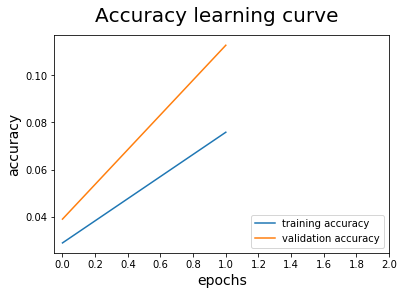

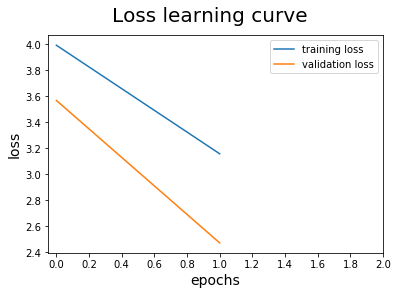

In [7]:
for i in range(len(files)):
    best_batch_size = 0
    best_learning_rate = 0
    best_history = None

    # Opening file for reading in binary mode
    with open('./data/data{}.pickle'.format(i), 'rb') as f:
        data = pickle.load(f, encoding='latin1')  # dictionary type
        print("Reading")
        print("./data/data{}.pickle".format(i))


    # Making channels come at the end
    X_train = data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
    X_val = data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
    X_test = data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

    y_train = data['y_train']
    y_val = data['y_validation']
    y_test = data['y_test']

    # Showing loaded data from file
    for k, j in data.items():
        if k == 'labels':
            print(k + ':', len(j))
        else:
            print(k + ':', j.shape)
    
    
    for bs in batch_size:

        print("-------------------")
        print("Compiling VGG16 model with {} batch size".format(bs))
        print("-------------------")

        model = vgg16_model()

        print("-------------------")
        print("Training VGG16 model with {} batch size".format(bs))
        print("-------------------")

        with tf.device('/device:GPU:0'):
            history = model.fit(X_train, y_train, batch_size=bs, epochs=epochs, validation_data=(X_val, y_val))

        predictions = model.predict(X_test, batch_size=bs)
        y_pred = [np.argmax(x) for x in predictions]
        score = accuracy_score(y_test, y_pred)
        print(score)

        if score > acc_scores[i]:
            acc_scores[i] = score
            best_batch_size = bs
            best_history = history

                
    best_results(best_history, file="{}/data{}_results_{}.txt".format(results, i, best_batch_size))
    generate_plots(i, best_history, plot_acc, plot_loss, best_batch_size)
                

